In [6]:
%cd /content
!rm -rf Gradu
!git clone https://github.com/Elkkujou/Gradu.git
%cd /content/Gradu
!ls

/content
Cloning into 'Gradu'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 256 (delta 60), reused 0 (delta 0), pack-reused 136 (from 1)
Receiving objects: 100% (256/256), 29.68 MiB | 22.31 MiB/s, done.
Resolving deltas: 100% (118/118), done.
/content/Gradu
 chatti_RF.ipynb	       regime_prediction_famafrench.ipynb  'RF REGIIMI HYVÄ TRAINING.ipynb'
'Financial turbulence.ipynb'   regime_prediction_msci.ipynb	   'RF_regime (3).ipynb'
 FT_source.xlsx		       regime_pred.txt			    THE_ONE.xlsx
 Regiimi_prediction.ipynb      RF_Gradu.ipynb


In [7]:
calc_drawdowns = True
drawdowns_from = 'USA MOMENTUM Standard (Large+Mid Cap)'
cluster_n = 3

DL = False
ML = True

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML
from sklearn.cluster import KMeans

In [9]:
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
excel_df = xls_file.parse("returns non-log")

excel_df.columns = excel_df.columns.get_level_values(0)
excel_df['Date'] = pd.to_datetime(excel_df['Date'])
excel_df.sort_values('Date', inplace=True)

print("Headers in the 'returns non-log' sheet:")
print(excel_df.columns)

Headers in the 'returns non-log' sheet:
Index(['Date', 'USA Standard (Large+Mid Cap)',
       'USA MOMENTUM Standard (Large+Mid Cap)',
       'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
       'USA RISK WEIGHTED Standard (Large+Mid Cap)',
       'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
       'USA ENHANCED VALUE Standard (Large+Mid Cap)', 'Winning Factor',
       'VIXCLS', 'GDPC1', 'CPI', 'LEI', '10yr', 'Financial Turbulance',
       '(Regime)', 'Financial condition', 'Drawdown', 'HY Spread', 'IG Spread',
       '10y-2y', 'Vix-regimes2', 'Vix-regimes3', 'FT_regimes2', 'FT_regimes3',
       'DD_regimes2', 'DD_regimes3', 'cluster_0 (minimal drawdown',
       'cluster_1 (moderate drawdown)', 'cluster_2 (severe drawdown)', 'SMB',
       'HML', 'RMW', 'CMA', 'MOM', '(Regimes)', 'Regimes'],
      dtype='object')


In [10]:
if calc_drawdowns:
    # Calculate the cumulative portfolio values using excel_df and the specified drawdowns_from column
    portfolio = (1 + excel_df[drawdowns_from]).cumprod()

    # Define a function to compute the maximum drawdown over a rolling window
    def max_dd(s):
        return (s / s.cummax() - 1).min()

    # Calculate the 3-month rolling drawdown using the portfolio series
    dd_series = portfolio.rolling(window=3, min_periods=3).apply(max_dd, raw=False)

    # Create a temporary DataFrame to store dates and the calculated drawdowns
    dd_temp = pd.DataFrame({
        'Date': excel_df['Date'],
        '3M_Max_Drawdown': dd_series
    })

    # Drop rows with missing drawdown data to ensure complete observations
    dd_temp = dd_temp.dropna()

    print("Drawdown calculation (temporary DataFrame):")
    print(dd_temp.head())


Drawdown calculation (temporary DataFrame):
        Date  3M_Max_Drawdown
2 1990-05-31        -0.014564
3 1990-06-29         0.000000
4 1990-07-31         0.000000
5 1990-08-31        -0.086261
6 1990-09-28        -0.128945


In [11]:
# Fit KMeans clustering on the temporary DataFrame's '3M_Max_Drawdown' column
kmeans = KMeans(n_clusters=cluster_n, random_state=42)
dd_temp['DD_cluster'] = kmeans.fit_predict(dd_temp[['3M_Max_Drawdown']])

# Merge the cluster labels from dd_temp into excel_df by matching on the 'Date' column.
# This adds a new column 'DD_cluster' to excel_df.
excel_df = excel_df.merge(dd_temp[['Date', 'DD_cluster']], on='Date', how='left')

print("excel_df with DD_cluster added:")
from IPython.display import display, HTML
display(HTML(excel_df.head().to_html(index=False)))


excel_df with DD_cluster added:


Date,USA Standard (Large+Mid Cap),USA MOMENTUM Standard (Large+Mid Cap),USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap),USA RISK WEIGHTED Standard (Large+Mid Cap),USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),USA ENHANCED VALUE Standard (Large+Mid Cap),Winning Factor,VIXCLS,GDPC1,CPI,LEI,10yr,Financial Turbulance,(Regime),Financial condition,Drawdown,HY Spread,IG Spread,10y-2y,Vix-regimes2,Vix-regimes3,FT_regimes2,FT_regimes3,DD_regimes2,DD_regimes3,cluster_0 (minimal drawdown,cluster_1 (moderate drawdown),cluster_2 (severe drawdown),SMB,HML,RMW,CMA,MOM,(Regimes),Regimes,DD_cluster
1990-03-30,0.020702,0.028022,0.012313,0.013039,0.036524,0.013845,USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),21.40,0.003630,0.004687,63.5,8.59,9.383220,Recovery,0.04713,0.000000,NaN,NaN,0.08,High,Low,Normal Turbulence,Low Turbulence,Normal Drawdown,Moderate Drawdown,1,0,0,0.0162,-0.0292,0.0204,-0.0102,0.0180,Normal,Normal,NaN
1990-04-30,-0.023292,-0.014564,-0.031345,-0.042294,-0.007806,-0.032085,USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),18.10,0.003630,0.002333,63.6,8.79,4.756642,Slowdown,-0.13602,-0.023292,NaN,NaN,0.10,High,High,Normal Turbulence,Low Turbulence,Normal Drawdown,Moderate Drawdown,1,0,0,-0.0033,-0.0259,0.0178,-0.0098,0.0239,Normal,Normal,NaN
1990-05-31,0.089444,0.112070,0.079487,0.080355,0.101743,0.081134,USA MOMENTUM Standard (Large+Mid Cap),16.82,0.003630,0.001552,63.3,8.76,14.686352,Slowdown,-0.15632,0.000000,NaN,NaN,0.19,High,High,Normal Turbulence,High Turbulence,Normal Drawdown,Moderate Drawdown,1,0,0,-0.0235,-0.0383,0.0157,-0.0168,0.0303,Normal,Normal,0.0
1990-06-29,-0.006432,0.022340,-0.010553,-0.010138,0.011909,-0.016679,USA MOMENTUM Standard (Large+Mid Cap),18.39,0.000666,0.006197,63.3,8.48,8.020190,Slowdown,0.08472,-0.006432,NaN,NaN,0.45,High,High,Normal Turbulence,Low Turbulence,Normal Drawdown,Moderate Drawdown,1,0,0,0.0135,-0.0193,-0.0103,-0.0039,0.0240,Normal,Normal,0.0
1990-07-31,-0.004276,0.004471,-0.001134,-0.011361,-0.000470,-0.008691,USA MOMENTUM Standard (Large+Mid Cap),28.18,0.000666,0.004619,63.3,8.47,25.637526,Slowdown,0.24339,-0.010680,NaN,NaN,0.79,Normal,Low,High Turbulence,High Turbulence,Normal Drawdown,Moderate Drawdown,1,0,0,-0.0316,-0.0003,-0.0018,0.0321,0.0610,Normal,Normal,0.0


In [12]:
#FEATURES = ['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial condition', '10y-2y', 'Financial Turbulance']

FEATURES = [
    'VIXCLS',
    'GDPC1',
    'CPI',
    'LEI',
    '10yr',
    'Financial Turbulance',
    'Financial condition',
    'HY Spread',
    'IG Spread',
    '10y-2y'
]


TRUE_REGIME = 'DD_cluster'
DATE = 'Date'

selected_columns =  [DATE] + [TRUE_REGIME] +FEATURES


In [13]:
missing = [col for col in selected_columns if col not in excel_df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

# Subset and drop rows with empty values
input_df = excel_df[selected_columns]
orig_rows = len(input_df)
input_df = input_df.dropna()
print(f"Original rows: {orig_rows}, Dropped rows: {orig_rows - len(input_df)}")
print(f"First obs: {input_df[DATE].min()}, Last obs: {input_df[DATE].max()}")

# Display as neat HTML table (adjust 'rows_to_show' as needed)
rows_to_show = 10
from IPython.display import display, HTML
display(HTML(input_df.head(rows_to_show).to_html(index=False)))

Original rows: 416, Dropped rows: 81
First obs: 1996-12-31 00:00:00, Last obs: 2024-10-31 00:00:00


Date,DD_cluster,VIXCLS,GDPC1,CPI,LEI,10yr,Financial Turbulance,Financial condition,HY Spread,IG Spread,10y-2y
1996-12-31,1.0,19.47,0.006454,0.002520,77.7,6.30,7.860576,0.00043,3.04,0.61,0.59
1997-01-31,1.0,20.14,0.006454,0.001886,77.8,6.58,14.956959,-0.03500,2.73,0.59,0.47
1997-02-28,0.0,20.17,0.006454,0.001882,78.3,6.42,13.043063,0.05391,2.84,0.57,0.47
1997-03-31,1.0,19.66,0.016652,0.000626,79.3,6.69,10.821978,0.05726,2.94,0.59,0.43
1997-04-30,1.0,19.92,0.016652,0.000626,79.7,6.89,10.938933,0.00925,2.68,0.61,0.45
1997-05-30,0.0,20.19,0.016652,0.000000,79.9,6.71,4.038058,-0.01056,2.67,0.58,0.43
1997-06-30,0.0,20.53,0.012486,0.001876,80.4,6.49,7.517614,-0.02150,2.71,0.56,0.28
1997-07-31,0.0,23.08,0.012486,0.001248,81.1,6.22,14.684361,0.01571,2.59,0.57,0.37
1997-08-29,1.0,23.81,0.012486,0.002494,82.0,6.30,10.252527,0.03394,2.59,0.54,0.32
1997-09-30,1.0,23.87,0.008539,0.002488,82.3,6.21,6.511195,0.10651,2.99,0.67,0.21


In [14]:
from tabulate import tabulate

# Calculate the number of observations for each regime in the data
regime_counts = input_df[TRUE_REGIME].value_counts().sort_index().reset_index()
regime_counts.columns = [TRUE_REGIME, 'Count']

print("Number of observations per regime:")
print(tabulate(regime_counts, headers='keys', tablefmt='psql', showindex=False))


Number of observations per regime:
+--------------+---------+
|   DD_cluster |   Count |
|--------------+---------|
|            0 |     204 |
|            1 |     102 |
|            2 |      29 |
+--------------+---------+


Starting rolling window evaluation:
Skipping prediction for timestamp 1996-12-31 00:00:00 (insufficient data: 0 observations available, need 60).
Skipping prediction for timestamp 1997-01-31 00:00:00 (insufficient data: 1 observations available, need 60).
Skipping prediction for timestamp 1997-02-28 00:00:00 (insufficient data: 2 observations available, need 60).
Skipping prediction for timestamp 1997-03-31 00:00:00 (insufficient data: 3 observations available, need 60).
Skipping prediction for timestamp 1997-04-30 00:00:00 (insufficient data: 4 observations available, need 60).
Skipping prediction for timestamp 1997-05-30 00:00:00 (insufficient data: 5 observations available, need 60).
Skipping prediction for timestamp 1997-06-30 00:00:00 (insufficient data: 6 observations available, need 60).
Skipping prediction for timestamp 1997-07-31 00:00:00 (insufficient data: 7 observations available, need 60).
Skipping prediction for timestamp 1997-08-29 00:00:00 (insufficient data: 8 observat

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2001-12-31 00:00:00 - Prediction for period 2002-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2001-12-31 00:00:00 - Prediction for period 2002-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2001-12-31 00:00:00 - Prediction for period 2002-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2001-12-31 00:00:00 - Prediction for period 2002-01-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2001-12-31 00:00:00 - Prediction for period 2002-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-01-31 00:00:00 - Prediction for period 2002-02-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-01-31 00:00:00 - Prediction for period 2002-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2002-01-31 00:00:00 - Prediction for period 2002-02-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2002-01-31 00:00:00 - Prediction for period 2002-02-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2002-01-31 00:00:00 - Prediction for period 2002-02-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-02-28 00:00:00 - Prediction for period 2002-03-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-02-28 00:00:00 - Prediction for period 2002-03-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2002-02-28 00:00:00 - Prediction for period 2002-03-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-02-28 00:00:00 - Prediction for period 2002-03-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2002-02-28 00:00:00 - Prediction for period 2002-03-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2002-03-29 00:00:00 - Prediction for period 2002-04-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-03-29 00:00:00 - Prediction for period 2002-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-03-29 00:00:00 - Prediction for period 2002-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2002-03-29 00:00:00 - Prediction for period 2002-04-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2002-03-29 00:00:00 - Prediction for period 2002-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2002-04-30 00:00:00 - Prediction for period 2002-05-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-04-30 00:00:00 - Prediction for period 2002-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-04-30 00:00:00 - Prediction for period 2002-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-04-30 00:00:00 - Prediction for period 2002-05-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-04-30 00:00:00 - Prediction for period 2002-05-31 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-05-31 00:00:00 - Prediction for period 2002-06-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-05-31 00:00:00 - Prediction for period 2002-06-28 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-05-31 00:00:00 - Prediction for period 2002-06-28 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-05-31 00:00:00 - Prediction for period 2002-06-28 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-05-31 00:00:00 - Prediction for period 2002-06-28 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-06-28 00:00:00 - Prediction for period 2002-07-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-06-28 00:00:00 - Prediction for period 2002-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-06-28 00:00:00 - Prediction for period 2002-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2002-06-28 00:00:00 - Prediction for period 2002-07-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-06-28 00:00:00 - Prediction for period 2002-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-07-31 00:00:00 - Prediction for period 2002-08-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-07-31 00:00:00 - Prediction for period 2002-08-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-07-31 00:00:00 - Prediction for period 2002-08-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-07-31 00:00:00 - Prediction for period 2002-08-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-07-31 00:00:00 - Prediction for period 2002-08-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2002-08-30 00:00:00 - Prediction for period 2002-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-08-30 00:00:00 - Prediction for period 2002-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-08-30 00:00:00 - Prediction for period 2002-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-08-30 00:00:00 - Prediction for period 2002-09-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2002-08-30 00:00:00 - Prediction for period 2002-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2002-09-30 00:00:00 - Prediction for period 2002-10-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-09-30 00:00:00 - Prediction for period 2002-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-09-30 00:00:00 - Prediction for period 2002-10-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-09-30 00:00:00 - Prediction for period 2002-10-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-09-30 00:00:00 - Prediction for period 2002-10-31 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-10-31 00:00:00 - Prediction for period 2002-11-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-10-31 00:00:00 - Prediction for period 2002-11-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-10-31 00:00:00 - Prediction for period 2002-11-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2002-10-31 00:00:00 - Prediction for period 2002-11-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2002-10-31 00:00:00 - Prediction for period 2002-11-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-11-29 00:00:00 - Prediction for period 2002-12-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2002-11-29 00:00:00 - Prediction for period 2002-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-11-29 00:00:00 - Prediction for period 2002-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2002-11-29 00:00:00 - Prediction for period 2002-12-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2002-11-29 00:00:00 - Prediction for period 2002-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2002-12-31 00:00:00 - Prediction for period 2003-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2002-12-31 00:00:00 - Prediction for period 2003-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2002-12-31 00:00:00 - Prediction for period 2003-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2002-12-31 00:00:00 - Prediction for period 2003-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2002-12-31 00:00:00 - Prediction for period 2003-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-01-31 00:00:00 - Prediction for period 2003-02-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-01-31 00:00:00 - Prediction for period 2003-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-01-31 00:00:00 - Prediction for period 2003-02-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-01-31 00:00:00 - Prediction for period 2003-02-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-01-31 00:00:00 - Prediction for period 2003-02-28 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2003-02-28 00:00:00 - Prediction for period 2003-03-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-02-28 00:00:00 - Prediction for period 2003-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-02-28 00:00:00 - Prediction for period 2003-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-02-28 00:00:00 - Prediction for period 2003-03-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2003-02-28 00:00:00 - Prediction for period 2003-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2003-03-31 00:00:00 - Prediction for period 2003-04-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-03-31 00:00:00 - Prediction for period 2003-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-03-31 00:00:00 - Prediction for period 2003-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-03-31 00:00:00 - Prediction for period 2003-04-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-03-31 00:00:00 - Prediction for period 2003-04-30 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-04-30 00:00:00 - Prediction for period 2003-05-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-04-30 00:00:00 - Prediction for period 2003-05-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-04-30 00:00:00 - Prediction for period 2003-05-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-04-30 00:00:00 - Prediction for period 2003-05-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-04-30 00:00:00 - Prediction for period 2003-05-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-05-30 00:00:00 - Prediction for period 2003-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-05-30 00:00:00 - Prediction for period 2003-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-05-30 00:00:00 - Prediction for period 2003-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-05-30 00:00:00 - Prediction for period 2003-06-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-05-30 00:00:00 - Prediction for period 2003-06-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-06-30 00:00:00 - Prediction for period 2003-07-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-06-30 00:00:00 - Prediction for period 2003-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2003-06-30 00:00:00 - Prediction for period 2003-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-06-30 00:00:00 - Prediction for period 2003-07-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-06-30 00:00:00 - Prediction for period 2003-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-07-31 00:00:00 - Prediction for period 2003-08-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-07-31 00:00:00 - Prediction for period 2003-08-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-07-31 00:00:00 - Prediction for period 2003-08-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-07-31 00:00:00 - Prediction for period 2003-08-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-07-31 00:00:00 - Prediction for period 2003-08-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2003-08-29 00:00:00 - Prediction for period 2003-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-08-29 00:00:00 - Prediction for period 2003-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-08-29 00:00:00 - Prediction for period 2003-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-08-29 00:00:00 - Prediction for period 2003-09-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-08-29 00:00:00 - Prediction for period 2003-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-09-30 00:00:00 - Prediction for period 2003-10-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-09-30 00:00:00 - Prediction for period 2003-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-09-30 00:00:00 - Prediction for period 2003-10-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-09-30 00:00:00 - Prediction for period 2003-10-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-09-30 00:00:00 - Prediction for period 2003-10-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2003-10-31 00:00:00 - Prediction for period 2003-11-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-10-31 00:00:00 - Prediction for period 2003-11-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-10-31 00:00:00 - Prediction for period 2003-11-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2003-10-31 00:00:00 - Prediction for period 2003-11-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-10-31 00:00:00 - Prediction for period 2003-11-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2003-11-28 00:00:00 - Prediction for period 2003-12-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-11-28 00:00:00 - Prediction for period 2003-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-11-28 00:00:00 - Prediction for period 2003-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-11-28 00:00:00 - Prediction for period 2003-12-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-11-28 00:00:00 - Prediction for period 2003-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2003-12-31 00:00:00 - Prediction for period 2004-01-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2003-12-31 00:00:00 - Prediction for period 2004-01-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2003-12-31 00:00:00 - Prediction for period 2004-01-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2003-12-31 00:00:00 - Prediction for period 2004-01-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2003-12-31 00:00:00 - Prediction for period 2004-01-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-01-30 00:00:00 - Prediction for period 2004-02-27 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-01-30 00:00:00 - Prediction for period 2004-02-27 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2004-01-30 00:00:00 - Prediction for period 2004-02-27 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-01-30 00:00:00 - Prediction for period 2004-02-27 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-01-30 00:00:00 - Prediction for period 2004-02-27 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-02-27 00:00:00 - Prediction for period 2004-03-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-02-27 00:00:00 - Prediction for period 2004-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-02-27 00:00:00 - Prediction for period 2004-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-02-27 00:00:00 - Prediction for period 2004-03-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-02-27 00:00:00 - Prediction for period 2004-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-03-31 00:00:00 - Prediction for period 2004-04-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2004-03-31 00:00:00 - Prediction for period 2004-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-03-31 00:00:00 - Prediction for period 2004-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-03-31 00:00:00 - Prediction for period 2004-04-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2004-03-31 00:00:00 - Prediction for period 2004-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2004-04-30 00:00:00 - Prediction for period 2004-05-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2004-04-30 00:00:00 - Prediction for period 2004-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-04-30 00:00:00 - Prediction for period 2004-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2004-04-30 00:00:00 - Prediction for period 2004-05-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-04-30 00:00:00 - Prediction for period 2004-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2004-05-31 00:00:00 - Prediction for period 2004-06-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2004-05-31 00:00:00 - Prediction for period 2004-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-05-31 00:00:00 - Prediction for period 2004-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-05-31 00:00:00 - Prediction for period 2004-06-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-05-31 00:00:00 - Prediction for period 2004-06-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-06-30 00:00:00 - Prediction for period 2004-07-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2004-06-30 00:00:00 - Prediction for period 2004-07-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-06-30 00:00:00 - Prediction for period 2004-07-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2004-06-30 00:00:00 - Prediction for period 2004-07-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2004-06-30 00:00:00 - Prediction for period 2004-07-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-07-30 00:00:00 - Prediction for period 2004-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-07-30 00:00:00 - Prediction for period 2004-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2004-07-30 00:00:00 - Prediction for period 2004-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2004-07-30 00:00:00 - Prediction for period 2004-08-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-07-30 00:00:00 - Prediction for period 2004-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2004-08-31 00:00:00 - Prediction for period 2004-09-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2004-08-31 00:00:00 - Prediction for period 2004-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-08-31 00:00:00 - Prediction for period 2004-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-08-31 00:00:00 - Prediction for period 2004-09-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2004-08-31 00:00:00 - Prediction for period 2004-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-09-30 00:00:00 - Prediction for period 2004-10-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2004-09-30 00:00:00 - Prediction for period 2004-10-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2004-09-30 00:00:00 - Prediction for period 2004-10-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-09-30 00:00:00 - Prediction for period 2004-10-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-09-30 00:00:00 - Prediction for period 2004-10-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-10-29 00:00:00 - Prediction for period 2004-11-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-10-29 00:00:00 - Prediction for period 2004-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2004-10-29 00:00:00 - Prediction for period 2004-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-10-29 00:00:00 - Prediction for period 2004-11-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-10-29 00:00:00 - Prediction for period 2004-11-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-11-30 00:00:00 - Prediction for period 2004-12-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-11-30 00:00:00 - Prediction for period 2004-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2004-11-30 00:00:00 - Prediction for period 2004-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-11-30 00:00:00 - Prediction for period 2004-12-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-11-30 00:00:00 - Prediction for period 2004-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2004-12-31 00:00:00 - Prediction for period 2005-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2004-12-31 00:00:00 - Prediction for period 2005-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2004-12-31 00:00:00 - Prediction for period 2005-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2004-12-31 00:00:00 - Prediction for period 2005-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2004-12-31 00:00:00 - Prediction for period 2005-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2005-01-31 00:00:00 - Prediction for period 2005-02-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-01-31 00:00:00 - Prediction for period 2005-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-01-31 00:00:00 - Prediction for period 2005-02-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-01-31 00:00:00 - Prediction for period 2005-02-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-01-31 00:00:00 - Prediction for period 2005-02-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2005-02-28 00:00:00 - Prediction for period 2005-03-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2005-02-28 00:00:00 - Prediction for period 2005-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2005-02-28 00:00:00 - Prediction for period 2005-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2005-02-28 00:00:00 - Prediction for period 2005-03-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-02-28 00:00:00 - Prediction for period 2005-03-31 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-03-31 00:00:00 - Prediction for period 2005-04-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2005-03-31 00:00:00 - Prediction for period 2005-04-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2005-03-31 00:00:00 - Prediction for period 2005-04-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2005-03-31 00:00:00 - Prediction for period 2005-04-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-03-31 00:00:00 - Prediction for period 2005-04-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2005-04-29 00:00:00 - Prediction for period 2005-05-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2005-04-29 00:00:00 - Prediction for period 2005-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2005-04-29 00:00:00 - Prediction for period 2005-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2005-04-29 00:00:00 - Prediction for period 2005-05-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2005-04-29 00:00:00 - Prediction for period 2005-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-05-31 00:00:00 - Prediction for period 2005-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-05-31 00:00:00 - Prediction for period 2005-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2005-05-31 00:00:00 - Prediction for period 2005-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-05-31 00:00:00 - Prediction for period 2005-06-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-05-31 00:00:00 - Prediction for period 2005-06-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-06-30 00:00:00 - Prediction for period 2005-07-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-06-30 00:00:00 - Prediction for period 2005-07-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-06-30 00:00:00 - Prediction for period 2005-07-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-06-30 00:00:00 - Prediction for period 2005-07-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-06-30 00:00:00 - Prediction for period 2005-07-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-07-29 00:00:00 - Prediction for period 2005-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-07-29 00:00:00 - Prediction for period 2005-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-07-29 00:00:00 - Prediction for period 2005-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2005-07-29 00:00:00 - Prediction for period 2005-08-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-07-29 00:00:00 - Prediction for period 2005-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-08-31 00:00:00 - Prediction for period 2005-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-08-31 00:00:00 - Prediction for period 2005-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-08-31 00:00:00 - Prediction for period 2005-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2005-08-31 00:00:00 - Prediction for period 2005-09-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2005-08-31 00:00:00 - Prediction for period 2005-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-09-30 00:00:00 - Prediction for period 2005-10-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-09-30 00:00:00 - Prediction for period 2005-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-09-30 00:00:00 - Prediction for period 2005-10-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2005-09-30 00:00:00 - Prediction for period 2005-10-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2005-09-30 00:00:00 - Prediction for period 2005-10-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-10-31 00:00:00 - Prediction for period 2005-11-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-10-31 00:00:00 - Prediction for period 2005-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-10-31 00:00:00 - Prediction for period 2005-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2005-10-31 00:00:00 - Prediction for period 2005-11-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2005-10-31 00:00:00 - Prediction for period 2005-11-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-11-30 00:00:00 - Prediction for period 2005-12-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-11-30 00:00:00 - Prediction for period 2005-12-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2005-11-30 00:00:00 - Prediction for period 2005-12-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2005-11-30 00:00:00 - Prediction for period 2005-12-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-11-30 00:00:00 - Prediction for period 2005-12-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-12-30 00:00:00 - Prediction for period 2006-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2005-12-30 00:00:00 - Prediction for period 2006-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2005-12-30 00:00:00 - Prediction for period 2006-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2005-12-30 00:00:00 - Prediction for period 2006-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2005-12-30 00:00:00 - Prediction for period 2006-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2006-01-31 00:00:00 - Prediction for period 2006-02-28 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2006-01-31 00:00:00 - Prediction for period 2006-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-01-31 00:00:00 - Prediction for period 2006-02-28 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2006-01-31 00:00:00 - Prediction for period 2006-02-28 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2006-01-31 00:00:00 - Prediction for period 2006-02-28 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2006-02-28 00:00:00 - Prediction for period 2006-03-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-02-28 00:00:00 - Prediction for period 2006-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-02-28 00:00:00 - Prediction for period 2006-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-02-28 00:00:00 - Prediction for period 2006-03-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2006-02-28 00:00:00 - Prediction for period 2006-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2006-03-31 00:00:00 - Prediction for period 2006-04-28 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2006-03-31 00:00:00 - Prediction for period 2006-04-28 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2006-03-31 00:00:00 - Prediction for period 2006-04-28 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2006-03-31 00:00:00 - Prediction for period 2006-04-28 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2006-03-31 00:00:00 - Prediction for period 2006-04-28 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-04-28 00:00:00 - Prediction for period 2006-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-04-28 00:00:00 - Prediction for period 2006-05-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2006-04-28 00:00:00 - Prediction for period 2006-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2006-05-31 00:00:00 - Prediction for period 2006-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-05-31 00:00:00 - Prediction for period 2006-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2006-05-31 00:00:00 - Prediction for period 2006-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-05-31 00:00:00 - Prediction for period 2006-06-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2006-05-31 00:00:00 - Prediction for period 2006-06-30 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-06-30 00:00:00 - Prediction for period 2006-07-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-06-30 00:00:00 - Prediction for period 2006-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2006-06-30 00:00:00 - Prediction for period 2006-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-06-30 00:00:00 - Prediction for period 2006-07-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2006-06-30 00:00:00 - Prediction for period 2006-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-07-31 00:00:00 - Prediction for period 2006-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-07-31 00:00:00 - Prediction for period 2006-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2006-07-31 00:00:00 - Prediction for period 2006-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2006-07-31 00:00:00 - Prediction for period 2006-08-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2006-07-31 00:00:00 - Prediction for period 2006-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2006-08-31 00:00:00 - Prediction for period 2006-09-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2006-08-31 00:00:00 - Prediction for period 2006-09-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2006-08-31 00:00:00 - Prediction for period 2006-09-29 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2006-10-31 00:00:00 - Prediction for period 2006-11-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-10-31 00:00:00 - Prediction for period 2006-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2006-10-31 00:00:00 - Prediction for period 2006-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-10-31 00:00:00 - Prediction for period 2006-11-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training period ended at 2006-10-31 00:00:00 - Prediction for period 2006-11-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2006-11-30 00:00:00 - Prediction for period 2006-12-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-11-30 00:00:00 - Prediction for period 2006-12-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2006-11-30 00:00:00 - Prediction for period 2006-12-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2006-11-30 00:00:00 - Prediction for period 2006-12-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2006-11-30 00:00:00 - Prediction for period 2006-12-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2006-12-29 00:00:00 - Prediction for period 2007-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2006-12-29 00:00:00 - Prediction for period 2007-01-31 00:00:00: Model 'GradientBoostin

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2007-03-30 00:00:00 - Prediction for period 2007-04-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2007-03-30 00:00:00 - Prediction for period 2007-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2007-03-30 00:00:00 - Prediction for period 2007-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2007-03-30 00:00:00 - Prediction for period 2007-04-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2007-03-30 00:00:00 - Prediction for period 2007-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2007-04-30 00:00:00 - Prediction for period 2007-05-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2007-04-30 00:00:00 - Prediction for period 2007-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2007-04-30 00:00:00 - Prediction for period 2007-05-31 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2007-05-31 00:00:00 - Prediction for period 2007-06-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2007-05-31 00:00:00 - Prediction for period 2007-06-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2007-05-31 00:00:00 - Prediction for period 2007-06-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2007-05-31 00:00:00 - Prediction for period 2007-06-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2007-05-31 00:00:00 - Prediction for period 2007-06-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2007-06-29 00:00:00 - Prediction for period 2007-07-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2007-06-29 00:00:00 - Prediction for period 2007-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2007-06-29 00:00:00 - Prediction for period 2007-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2007-06-29 00:00:00 - Prediction for period 2007-07-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2007-06-29 00:00:00 - Prediction for period 2007-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2007-07-31 00:00:00 - Prediction for period 2007-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2007-07-31 00:00:00 - Prediction for period 2007-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2007-07-31 00:00:00 - Prediction for period 2007-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2007-07-31 00:00:00 - Prediction for period 2007-08-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2007-07-31 00:00:00 - Prediction for period 2007-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2007-08-31 00:00:00 - Prediction for period 2007-09-28 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2007-08-31 00:00:00 - Prediction for period 2007-09-28 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2007-08-31 00:00:00 - Prediction for period 2007-09-28 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2008-02-29 00:00:00 - Prediction for period 2008-03-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2008-02-29 00:00:00 - Prediction for period 2008-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2008-02-29 00:00:00 - Prediction for period 2008-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2008-02-29 00:00:00 - Prediction for period 2008-03-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2008-02-29 00:00:00 - Prediction for period 2008-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2008-03-31 00:00:00 - Prediction for period 2008-04-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2008-03-31 00:00:00 - Prediction for period 2008-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2008-03-31 00:00:00 - Prediction for period 2008-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2008-03-31 00:00:00 - Prediction for period 2008-04-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2008-03-31 00:00:00 - Prediction for period 2008-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2008-04-30 00:00:00 - Prediction for period 2008-05-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2008-04-30 00:00:00 - Prediction for period 2008-05-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2008-04-30 00:00:00 - Prediction for period 2008-05-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2008-04-30 00:00:00 - Prediction for period 2008-05-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2008-04-30 00:00:00 - Prediction for period 2008-05-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2008-05-30 00:00:00 - Prediction for period 2008-06-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2008-05-30 00:00:00 - Prediction for period 2008-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2008-05-30 00:00:00 - Prediction for period 2008-06-30 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2008-07-31 00:00:00 - Prediction for period 2008-08-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2008-07-31 00:00:00 - Prediction for period 2008-08-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2008-07-31 00:00:00 - Prediction for period 2008-08-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2008-07-31 00:00:00 - Prediction for period 2008-08-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2008-07-31 00:00:00 - Prediction for period 2008-08-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2008-08-29 00:00:00 - Prediction for period 2008-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2008-08-29 00:00:00 - Prediction for period 2008-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2008-08-29 00:00:00 - Prediction for period 2008-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2008-08-29 00:00:00 - Prediction for period 2008-09-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2008-08-29 00:00:00 - Prediction for period 2008-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2008-09-30 00:00:00 - Prediction for period 2008-10-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2008-09-30 00:00:00 - Prediction for period 2008-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2008-09-30 00:00:00 - Prediction for period 2008-10-31 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2008-12-31 00:00:00 - Prediction for period 2009-01-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2009-01-30 00:00:00 - Prediction for period 2009-02-27 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2009-01-30 00:00:00 - Prediction for period 2009-02-27 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2009-01-30 00:00:00 - Prediction for period 2009-02-27 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-01-30 00:00:00 - Prediction for period 2009-02-27 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2009-01-30 00:00:00 - Prediction for period 2009-02-27 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2009-02-27 00:00:00 - Prediction for period 2009-03-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2009-02-27 00:00:00 - Prediction for period 2009-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2009-02-27 00:00:00 - Prediction for period 2009-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2009-02-27 00:00:00 - Prediction for period 2009-03-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2009-02-27 00:00:00 - Prediction for period 2009-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-03-31 00:00:00 - Prediction for period 2009-04-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2009-03-31 00:00:00 - Prediction for period 2009-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-03-31 00:00:00 - Prediction for period 2009-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2009-03-31 00:00:00 - Prediction for period 2009-04-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2009-03-31 00:00:00 - Prediction for period 2009-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2009-04-30 00:00:00 - Prediction for period 2009-05-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2009-04-30 00:00:00 - Prediction for period 2009-05-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-04-30 00:00:00 - Prediction for period 2009-05-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2009-04-30 00:00:00 - Prediction for period 2009-05-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2009-04-30 00:00:00 - Prediction for period 2009-05-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2009-05-29 00:00:00 - Prediction for period 2009-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2009-05-29 00:00:00 - Prediction for period 2009-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2009-05-29 00:00:00 - Prediction for period 2009-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2009-05-29 00:00:00 - Prediction for period 2009-06-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2009-05-29 00:00:00 - Prediction for period 2009-06-30 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-07-31 00:00:00 - Prediction for period 2009-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2009-07-31 00:00:00 - Prediction for period 2009-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2009-07-31 00:00:00 - Prediction for period 2009-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2009-07-31 00:00:00 - Prediction for period 2009-08-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-07-31 00:00:00 - Prediction for period 2009-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2009-08-31 00:00:00 - Prediction for period 2009-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2009-08-31 00:00:00 - Prediction for period 2009-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2009-08-31 00:00:00 - Prediction for period 2009-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2009-08-31 00:00:00 - Prediction for period 2009-09-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2009-08-31 00:00:00 - Prediction for period 2009-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-09-30 00:00:00 - Prediction for period 2009-10-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2009-09-30 00:00:00 - Prediction for period 2009-10-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2009-09-30 00:00:00 - Prediction for period 2009-10-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2009-09-30 00:00:00 - Prediction for period 2009-10-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2009-09-30 00:00:00 - Prediction for period 2009-10-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-10-30 00:00:00 - Prediction for period 2009-11-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2009-10-30 00:00:00 - Prediction for period 2009-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2009-10-30 00:00:00 - Prediction for period 2009-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2009-10-30 00:00:00 - Prediction for period 2009-11-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2009-10-30 00:00:00 - Prediction for period 2009-11-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-11-30 00:00:00 - Prediction for period 2009-12-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2009-11-30 00:00:00 - Prediction for period 2009-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2009-11-30 00:00:00 - Prediction for period 2009-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2009-11-30 00:00:00 - Prediction for period 2009-12-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2009-11-30 00:00:00 - Prediction for period 2009-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2009-12-31 00:00:00 - Prediction for period 2010-01-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2009-12-31 00:00:00 - Prediction for period 2010-01-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2009-12-31 00:00:00 - Prediction for period 2010-01-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2009-12-31 00:00:00 - Prediction for period 2010-01-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2009-12-31 00:00:00 - Prediction for period 2010-01-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-01-29 00:00:00 - Prediction for period 2010-02-26 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2010-01-29 00:00:00 - Prediction for period 2010-02-26 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2010-01-29 00:00:00 - Prediction for period 2010-02-26 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2010-01-29 00:00:00 - Prediction for period 2010-02-26 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2010-01-29 00:00:00 - Prediction for period 2010-02-26 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-02-26 00:00:00 - Prediction for period 2010-03-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2010-02-26 00:00:00 - Prediction for period 2010-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2010-02-26 00:00:00 - Prediction for period 2010-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-02-26 00:00:00 - Prediction for period 2010-03-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2010-02-26 00:00:00 - Prediction for period 2010-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2010-03-31 00:00:00 - Prediction for period 2010-04-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2010-03-31 00:00:00 - Prediction for period 2010-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2010-03-31 00:00:00 - Prediction for period 2010-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2010-03-31 00:00:00 - Prediction for period 2010-04-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2010-03-31 00:00:00 - Prediction for period 2010-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-04-30 00:00:00 - Prediction for period 2010-05-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2010-04-30 00:00:00 - Prediction for period 2010-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2010-04-30 00:00:00 - Prediction for period 2010-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2010-04-30 00:00:00 - Prediction for period 2010-05-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2010-04-30 00:00:00 - Prediction for period 2010-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-05-31 00:00:00 - Prediction for period 2010-06-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2010-05-31 00:00:00 - Prediction for period 2010-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2010-05-31 00:00:00 - Prediction for period 2010-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2010-05-31 00:00:00 - Prediction for period 2010-06-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2010-05-31 00:00:00 - Prediction for period 2010-06-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-06-30 00:00:00 - Prediction for period 2010-07-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2010-06-30 00:00:00 - Prediction for period 2010-07-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2010-06-30 00:00:00 - Prediction for period 2010-07-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2010-06-30 00:00:00 - Prediction for period 2010-07-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2010-06-30 00:00:00 - Prediction for period 2010-07-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-07-30 00:00:00 - Prediction for period 2010-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2010-07-30 00:00:00 - Prediction for period 2010-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-07-30 00:00:00 - Prediction for period 2010-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2010-07-30 00:00:00 - Prediction for period 2010-08-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2010-07-30 00:00:00 - Prediction for period 2010-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2010-08-31 00:00:00 - Prediction for period 2010-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2010-08-31 00:00:00 - Prediction for period 2010-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-08-31 00:00:00 - Prediction for period 2010-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2010-08-31 00:00:00 - Prediction for period 2010-09-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2010-08-31 00:00:00 - Prediction for period 2010-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2010-09-30 00:00:00 - Prediction for period 2010-10-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2010-09-30 00:00:00 - Prediction for period 2010-10-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-09-30 00:00:00 - Prediction for period 2010-10-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2010-09-30 00:00:00 - Prediction for period 2010-10-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2010-09-30 00:00:00 - Prediction for period 2010-10-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2010-10-29 00:00:00 - Prediction for period 2010-11-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2010-10-29 00:00:00 - Prediction for period 2010-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2010-10-29 00:00:00 - Prediction for period 2010-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2010-10-29 00:00:00 - Prediction for period 2010-11-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2010-10-29 00:00:00 - Prediction for period 2010-11-30 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-11-30 00:00:00 - Prediction for period 2010-12-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2010-11-30 00:00:00 - Prediction for period 2010-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2010-11-30 00:00:00 - Prediction for period 2010-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2010-11-30 00:00:00 - Prediction for period 2010-12-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2010-11-30 00:00:00 - Prediction for period 2010-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2010-12-31 00:00:00 - Prediction for period 2011-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2010-12-31 00:00:00 - Prediction for period 2011-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2010-12-31 00:00:00 - Prediction for period 2011-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2010-12-31 00:00:00 - Prediction for period 2011-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2010-12-31 00:00:00 - Prediction for period 2011-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-01-31 00:00:00 - Prediction for period 2011-02-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-01-31 00:00:00 - Prediction for period 2011-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2011-01-31 00:00:00 - Prediction for period 2011-02-28 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2011-01-31 00:00:00 - Prediction for period 2011-02-28 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2011-01-31 00:00:00 - Prediction for period 2011-02-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-02-28 00:00:00 - Prediction for period 2011-03-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-02-28 00:00:00 - Prediction for period 2011-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2011-02-28 00:00:00 - Prediction for period 2011-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-02-28 00:00:00 - Prediction for period 2011-03-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-02-28 00:00:00 - Prediction for period 2011-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-03-31 00:00:00 - Prediction for period 2011-04-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-03-31 00:00:00 - Prediction for period 2011-04-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2011-03-31 00:00:00 - Prediction for period 2011-04-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-03-31 00:00:00 - Prediction for period 2011-04-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-03-31 00:00:00 - Prediction for period 2011-04-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-04-29 00:00:00 - Prediction for period 2011-05-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-04-29 00:00:00 - Prediction for period 2011-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2011-04-29 00:00:00 - Prediction for period 2011-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-04-29 00:00:00 - Prediction for period 2011-05-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-04-29 00:00:00 - Prediction for period 2011-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-05-31 00:00:00 - Prediction for period 2011-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-05-31 00:00:00 - Prediction for period 2011-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2011-05-31 00:00:00 - Prediction for period 2011-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-05-31 00:00:00 - Prediction for period 2011-06-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-05-31 00:00:00 - Prediction for period 2011-06-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-06-30 00:00:00 - Prediction for period 2011-07-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2011-06-30 00:00:00 - Prediction for period 2011-07-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2011-06-30 00:00:00 - Prediction for period 2011-07-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-06-30 00:00:00 - Prediction for period 2011-07-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2011-06-30 00:00:00 - Prediction for period 2011-07-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-07-29 00:00:00 - Prediction for period 2011-08-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2011-07-29 00:00:00 - Prediction for period 2011-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2011-07-29 00:00:00 - Prediction for period 2011-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-07-29 00:00:00 - Prediction for period 2011-08-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-07-29 00:00:00 - Prediction for period 2011-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-08-31 00:00:00 - Prediction for period 2011-09-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2011-08-31 00:00:00 - Prediction for period 2011-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2011-08-31 00:00:00 - Prediction for period 2011-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2011-08-31 00:00:00 - Prediction for period 2011-09-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2011-08-31 00:00:00 - Prediction for period 2011-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-09-30 00:00:00 - Prediction for period 2011-10-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-09-30 00:00:00 - Prediction for period 2011-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2011-09-30 00:00:00 - Prediction for period 2011-10-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-09-30 00:00:00 - Prediction for period 2011-10-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2011-09-30 00:00:00 - Prediction for period 2011-10-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-10-31 00:00:00 - Prediction for period 2011-11-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2011-10-31 00:00:00 - Prediction for period 2011-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-10-31 00:00:00 - Prediction for period 2011-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2011-10-31 00:00:00 - Prediction for period 2011-11-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2011-10-31 00:00:00 - Prediction for period 2011-11-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2011-11-30 00:00:00 - Prediction for period 2011-12-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-11-30 00:00:00 - Prediction for period 2011-12-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-11-30 00:00:00 - Prediction for period 2011-12-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-11-30 00:00:00 - Prediction for period 2011-12-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-11-30 00:00:00 - Prediction for period 2011-12-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2011-12-30 00:00:00 - Prediction for period 2012-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2011-12-30 00:00:00 - Prediction for period 2012-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2011-12-30 00:00:00 - Prediction for period 2012-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2011-12-30 00:00:00 - Prediction for period 2012-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2011-12-30 00:00:00 - Prediction for period 2012-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2012-01-31 00:00:00 - Prediction for period 2012-02-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-01-31 00:00:00 - Prediction for period 2012-02-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-01-31 00:00:00 - Prediction for period 2012-02-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-01-31 00:00:00 - Prediction for period 2012-02-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-01-31 00:00:00 - Prediction for period 2012-02-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2012-02-29 00:00:00 - Prediction for period 2012-03-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-02-29 00:00:00 - Prediction for period 2012-03-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-02-29 00:00:00 - Prediction for period 2012-03-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-02-29 00:00:00 - Prediction for period 2012-03-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-02-29 00:00:00 - Prediction for period 2012-03-30 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-03-30 00:00:00 - Prediction for period 2012-04-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-03-30 00:00:00 - Prediction for period 2012-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-03-30 00:00:00 - Prediction for period 2012-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-03-30 00:00:00 - Prediction for period 2012-04-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-03-30 00:00:00 - Prediction for period 2012-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-04-30 00:00:00 - Prediction for period 2012-05-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2012-04-30 00:00:00 - Prediction for period 2012-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-04-30 00:00:00 - Prediction for period 2012-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2012-04-30 00:00:00 - Prediction for period 2012-05-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2012-04-30 00:00:00 - Prediction for period 2012-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-05-31 00:00:00 - Prediction for period 2012-06-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2012-05-31 00:00:00 - Prediction for period 2012-06-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-05-31 00:00:00 - Prediction for period 2012-06-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-05-31 00:00:00 - Prediction for period 2012-06-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2012-05-31 00:00:00 - Prediction for period 2012-06-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2012-06-29 00:00:00 - Prediction for period 2012-07-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-06-29 00:00:00 - Prediction for period 2012-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-06-29 00:00:00 - Prediction for period 2012-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-06-29 00:00:00 - Prediction for period 2012-07-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-06-29 00:00:00 - Prediction for period 2012-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-07-31 00:00:00 - Prediction for period 2012-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-07-31 00:00:00 - Prediction for period 2012-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-07-31 00:00:00 - Prediction for period 2012-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-07-31 00:00:00 - Prediction for period 2012-08-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-07-31 00:00:00 - Prediction for period 2012-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-08-31 00:00:00 - Prediction for period 2012-09-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-08-31 00:00:00 - Prediction for period 2012-09-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-08-31 00:00:00 - Prediction for period 2012-09-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-08-31 00:00:00 - Prediction for period 2012-09-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-08-31 00:00:00 - Prediction for period 2012-09-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-09-28 00:00:00 - Prediction for period 2012-10-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-09-28 00:00:00 - Prediction for period 2012-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-09-28 00:00:00 - Prediction for period 2012-10-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-09-28 00:00:00 - Prediction for period 2012-10-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-09-28 00:00:00 - Prediction for period 2012-10-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-10-31 00:00:00 - Prediction for period 2012-11-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-10-31 00:00:00 - Prediction for period 2012-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2012-10-31 00:00:00 - Prediction for period 2012-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-10-31 00:00:00 - Prediction for period 2012-11-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-10-31 00:00:00 - Prediction for period 2012-11-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-11-30 00:00:00 - Prediction for period 2012-12-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-11-30 00:00:00 - Prediction for period 2012-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-11-30 00:00:00 - Prediction for period 2012-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2012-11-30 00:00:00 - Prediction for period 2012-12-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-11-30 00:00:00 - Prediction for period 2012-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-12-31 00:00:00 - Prediction for period 2013-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2012-12-31 00:00:00 - Prediction for period 2013-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2012-12-31 00:00:00 - Prediction for period 2013-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2012-12-31 00:00:00 - Prediction for period 2013-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2012-12-31 00:00:00 - Prediction for period 2013-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2013-01-31 00:00:00 - Prediction for period 2013-02-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-01-31 00:00:00 - Prediction for period 2013-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-01-31 00:00:00 - Prediction for period 2013-02-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-01-31 00:00:00 - Prediction for period 2013-02-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-01-31 00:00:00 - Prediction for period 2013-02-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-02-28 00:00:00 - Prediction for period 2013-03-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-02-28 00:00:00 - Prediction for period 2013-03-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-02-28 00:00:00 - Prediction for period 2013-03-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-02-28 00:00:00 - Prediction for period 2013-03-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-02-28 00:00:00 - Prediction for period 2013-03-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-03-29 00:00:00 - Prediction for period 2013-04-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-03-29 00:00:00 - Prediction for period 2013-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-03-29 00:00:00 - Prediction for period 2013-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-03-29 00:00:00 - Prediction for period 2013-04-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-03-29 00:00:00 - Prediction for period 2013-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2013-04-30 00:00:00 - Prediction for period 2013-05-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-04-30 00:00:00 - Prediction for period 2013-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-04-30 00:00:00 - Prediction for period 2013-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-04-30 00:00:00 - Prediction for period 2013-05-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-04-30 00:00:00 - Prediction for period 2013-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2013-05-31 00:00:00 - Prediction for period 2013-06-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-05-31 00:00:00 - Prediction for period 2013-06-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-05-31 00:00:00 - Prediction for period 2013-06-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-05-31 00:00:00 - Prediction for period 2013-06-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-05-31 00:00:00 - Prediction for period 2013-06-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2013-06-28 00:00:00 - Prediction for period 2013-07-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-06-28 00:00:00 - Prediction for period 2013-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-06-28 00:00:00 - Prediction for period 2013-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-06-28 00:00:00 - Prediction for period 2013-07-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-06-28 00:00:00 - Prediction for period 2013-07-31 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-07-31 00:00:00 - Prediction for period 2013-08-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2013-07-31 00:00:00 - Prediction for period 2013-08-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2013-07-31 00:00:00 - Prediction for period 2013-08-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2013-07-31 00:00:00 - Prediction for period 2013-08-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2013-07-31 00:00:00 - Prediction for period 2013-08-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-08-30 00:00:00 - Prediction for period 2013-09-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2013-08-30 00:00:00 - Prediction for period 2013-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-08-30 00:00:00 - Prediction for period 2013-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2013-08-30 00:00:00 - Prediction for period 2013-09-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2013-08-30 00:00:00 - Prediction for period 2013-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2013-09-30 00:00:00 - Prediction for period 2013-10-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2013-09-30 00:00:00 - Prediction for period 2013-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2013-09-30 00:00:00 - Prediction for period 2013-10-31 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-11-29 00:00:00 - Prediction for period 2013-12-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-11-29 00:00:00 - Prediction for period 2013-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2013-11-29 00:00:00 - Prediction for period 2013-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-11-29 00:00:00 - Prediction for period 2013-12-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-11-29 00:00:00 - Prediction for period 2013-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2013-12-31 00:00:00 - Prediction for period 2014-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2013-12-31 00:00:00 - Prediction for period 2014-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2013-12-31 00:00:00 - Prediction for period 2014-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2013-12-31 00:00:00 - Prediction for period 2014-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2013-12-31 00:00:00 - Prediction for period 2014-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2014-01-31 00:00:00 - Prediction for period 2014-02-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2014-01-31 00:00:00 - Prediction for period 2014-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2014-01-31 00:00:00 - Prediction for period 2014-02-28 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2014-03-31 00:00:00 - Prediction for period 2014-04-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2014-03-31 00:00:00 - Prediction for period 2014-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2014-04-30 00:00:00 - Prediction for period 2014-05-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2014-04-30 00:00:00 - Prediction for period 2014-05-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2014-04-30 00:00:00 - Prediction for period 2014-05-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2014-04-30 00:00:00 - Prediction for period 2014-05-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2014-04-30 00:00:00 - Prediction for period 2014-05-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2014-05-30 00:00:00 - Prediction for period 2014-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2014-05-30 00:00:00 - Prediction for period 2014-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2014-05-30 00:00:00 - Prediction for period 2014-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2014-05-30 00:00:00 - Prediction for period 2014-06-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2014-05-30 00:00:00 - Prediction for period 2014-06-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2014-06-30 00:00:00 - Prediction for period 2014-07-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2014-06-30 00:00:00 - Prediction for period 2014-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2014-06-30 00:00:00 - Prediction for period 2014-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2014-06-30 00:00:00 - Prediction for period 2014-07-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2014-06-30 00:00:00 - Prediction for period 2014-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2014-07-31 00:00:00 - Prediction for period 2014-08-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2014-07-31 00:00:00 - Prediction for period 2014-08-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2014-07-31 00:00:00 - Prediction for period 2014-08-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2014-07-31 00:00:00 - Prediction for period 2014-08-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2014-07-31 00:00:00 - Prediction for period 2014-08-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2014-08-29 00:00:00 - Prediction for period 2014-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2014-08-29 00:00:00 - Prediction for period 2014-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2014-08-29 00:00:00 - Prediction for period 2014-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2014-08-29 00:00:00 - Prediction for period 2014-09-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2014-08-29 00:00:00 - Prediction for period 2014-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2014-09-30 00:00:00 - Prediction for period 2014-10-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2014-09-30 00:00:00 - Prediction for period 2014-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2014-09-30 00:00:00 - Prediction for period 2014-10-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2014-09-30 00:00:00 - Prediction for period 2014-10-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2014-09-30 00:00:00 - Prediction for period 2014-10-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2014-10-31 00:00:00 - Prediction for period 2014-11-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2014-10-31 00:00:00 - Prediction for period 2014-11-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2014-10-31 00:00:00 - Prediction for period 2014-11-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2014-10-31 00:00:00 - Prediction for period 2014-11-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2014-10-31 00:00:00 - Prediction for period 2014-11-28 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2014-11-28 00:00:00 - Prediction for period 2014-12-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2014-11-28 00:00:00 - Prediction for period 2014-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2014-11-28 00:00:00 - Prediction for period 2014-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2014-11-28 00:00:00 - Prediction for period 2014-12-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2014-11-28 00:00:00 - Prediction for period 2014-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2014-12-31 00:00:00 - Prediction for period 2015-01-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2014-12-31 00:00:00 - Prediction for period 2015-01-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2014-12-31 00:00:00 - Prediction for period 2015-01-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2014-12-31 00:00:00 - Prediction for period 2015-01-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2014-12-31 00:00:00 - Prediction for period 2015-01-30 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2015-01-30 00:00:00 - Prediction for period 2015-02-27 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2015-01-30 00:00:00 - Prediction for period 2015-02-27 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2015-01-30 00:00:00 - Prediction for period 2015-02-27 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2015-01-30 00:00:00 - Prediction for period 2015-02-27 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2015-01-30 00:00:00 - Prediction for period 2015-02-27 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2015-02-27 00:00:00 - Prediction for period 2015-03-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2015-02-27 00:00:00 - Prediction for period 2015-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2015-02-27 00:00:00 - Prediction for period 2015-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2015-02-27 00:00:00 - Prediction for period 2015-03-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2015-02-27 00:00:00 - Prediction for period 2015-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2015-03-31 00:00:00 - Prediction for period 2015-04-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2015-03-31 00:00:00 - Prediction for period 2015-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2015-03-31 00:00:00 - Prediction for period 2015-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2015-03-31 00:00:00 - Prediction for period 2015-04-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2015-03-31 00:00:00 - Prediction for period 2015-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2015-04-30 00:00:00 - Prediction for period 2015-05-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2015-04-30 00:00:00 - Prediction for period 2015-05-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2015-04-30 00:00:00 - Prediction for period 2015-05-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2015-04-30 00:00:00 - Prediction for period 2015-05-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2015-04-30 00:00:00 - Prediction for period 2015-05-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2015-05-29 00:00:00 - Prediction for period 2015-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2015-05-29 00:00:00 - Prediction for period 2015-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2015-05-29 00:00:00 - Prediction for period 2015-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2015-05-29 00:00:00 - Prediction for period 2015-06-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2015-05-29 00:00:00 - Prediction for period 2015-06-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2015-06-30 00:00:00 - Prediction for period 2015-07-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2015-06-30 00:00:00 - Prediction for period 2015-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2015-06-30 00:00:00 - Prediction for period 2015-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2015-06-30 00:00:00 - Prediction for period 2015-07-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2015-06-30 00:00:00 - Prediction for period 2015-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2015-07-31 00:00:00 - Prediction for period 2015-08-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2015-07-31 00:00:00 - Prediction for period 2015-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2015-07-31 00:00:00 - Prediction for period 2015-08-31 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2015-12-31 00:00:00 - Prediction for period 2016-01-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2015-12-31 00:00:00 - Prediction for period 2016-01-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2015-12-31 00:00:00 - Prediction for period 2016-01-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2015-12-31 00:00:00 - Prediction for period 2016-01-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2015-12-31 00:00:00 - Prediction for period 2016-01-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2016-01-29 00:00:00 - Prediction for period 2016-02-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2016-01-29 00:00:00 - Prediction for period 2016-02-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2016-01-29 00:00:00 - Prediction for period 2016-02-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2016-01-29 00:00:00 - Prediction for period 2016-02-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2016-01-29 00:00:00 - Prediction for period 2016-02-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2016-02-29 00:00:00 - Prediction for period 2016-03-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2016-02-29 00:00:00 - Prediction for period 2016-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2016-02-29 00:00:00 - Prediction for period 2016-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2016-02-29 00:00:00 - Prediction for period 2016-03-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2016-02-29 00:00:00 - Prediction for period 2016-03-31 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2016-04-29 00:00:00 - Prediction for period 2016-05-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2016-04-29 00:00:00 - Prediction for period 2016-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2016-04-29 00:00:00 - Prediction for period 2016-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2016-04-29 00:00:00 - Prediction for period 2016-05-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2016-04-29 00:00:00 - Prediction for period 2016-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2016-05-31 00:00:00 - Prediction for period 2016-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2016-05-31 00:00:00 - Prediction for period 2016-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2016-05-31 00:00:00 - Prediction for period 2016-06-30 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2016-06-30 00:00:00 - Prediction for period 2016-07-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2016-06-30 00:00:00 - Prediction for period 2016-07-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2016-06-30 00:00:00 - Prediction for period 2016-07-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2016-06-30 00:00:00 - Prediction for period 2016-07-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2016-06-30 00:00:00 - Prediction for period 2016-07-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2016-07-29 00:00:00 - Prediction for period 2016-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2016-07-29 00:00:00 - Prediction for period 2016-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2016-07-29 00:00:00 - Prediction for period 2016-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2016-07-29 00:00:00 - Prediction for period 2016-08-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2016-07-29 00:00:00 - Prediction for period 2016-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2016-08-31 00:00:00 - Prediction for period 2016-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2016-08-31 00:00:00 - Prediction for period 2016-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2016-08-31 00:00:00 - Prediction for period 2016-09-30 00:00:00: Model 'Logisti

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2018-11-30 00:00:00 - Prediction for period 2018-12-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2018-11-30 00:00:00 - Prediction for period 2018-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2018-11-30 00:00:00 - Prediction for period 2018-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2018-11-30 00:00:00 - Prediction for period 2018-12-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2018-11-30 00:00:00 - Prediction for period 2018-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2018-12-31 00:00:00 - Prediction for period 2019-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2018-12-31 00:00:00 - Prediction for period 2019-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2018-12-31 00:00:00 - Prediction for period 2019-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2018-12-31 00:00:00 - Prediction for period 2019-01-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2018-12-31 00:00:00 - Prediction for period 2019-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-01-31 00:00:00 - Prediction for period 2019-02-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-01-31 00:00:00 - Prediction for period 2019-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2019-01-31 00:00:00 - Prediction for period 2019-02-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2019-01-31 00:00:00 - Prediction for period 2019-02-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-01-31 00:00:00 - Prediction for period 2019-02-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-02-28 00:00:00 - Prediction for period 2019-03-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-02-28 00:00:00 - Prediction for period 2019-03-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2019-02-28 00:00:00 - Prediction for period 2019-03-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2019-02-28 00:00:00 - Prediction for period 2019-03-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-02-28 00:00:00 - Prediction for period 2019-03-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-03-29 00:00:00 - Prediction for period 2019-04-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-03-29 00:00:00 - Prediction for period 2019-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2019-03-29 00:00:00 - Prediction for period 2019-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2019-03-29 00:00:00 - Prediction for period 2019-04-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-03-29 00:00:00 - Prediction for period 2019-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-04-30 00:00:00 - Prediction for period 2019-05-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-04-30 00:00:00 - Prediction for period 2019-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2019-04-30 00:00:00 - Prediction for period 2019-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2019-04-30 00:00:00 - Prediction for period 2019-05-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-04-30 00:00:00 - Prediction for period 2019-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2019-05-31 00:00:00 - Prediction for period 2019-06-28 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-05-31 00:00:00 - Prediction for period 2019-06-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2019-05-31 00:00:00 - Prediction for period 2019-06-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2019-05-31 00:00:00 - Prediction for period 2019-06-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-05-31 00:00:00 - Prediction for period 2019-06-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-06-28 00:00:00 - Prediction for period 2019-07-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-06-28 00:00:00 - Prediction for period 2019-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2019-06-28 00:00:00 - Prediction for period 2019-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2019-06-28 00:00:00 - Prediction for period 2019-07-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-06-28 00:00:00 - Prediction for period 2019-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-07-31 00:00:00 - Prediction for period 2019-08-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-07-31 00:00:00 - Prediction for period 2019-08-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2019-07-31 00:00:00 - Prediction for period 2019-08-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-07-31 00:00:00 - Prediction for period 2019-08-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-07-31 00:00:00 - Prediction for period 2019-08-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2019-08-30 00:00:00 - Prediction for period 2019-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-08-30 00:00:00 - Prediction for period 2019-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2019-08-30 00:00:00 - Prediction for period 2019-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2019-08-30 00:00:00 - Prediction for period 2019-09-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-08-30 00:00:00 - Prediction for period 2019-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-09-30 00:00:00 - Prediction for period 2019-10-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-09-30 00:00:00 - Prediction for period 2019-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2019-09-30 00:00:00 - Prediction for period 2019-10-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2019-09-30 00:00:00 - Prediction for period 2019-10-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-09-30 00:00:00 - Prediction for period 2019-10-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-10-31 00:00:00 - Prediction for period 2019-11-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-10-31 00:00:00 - Prediction for period 2019-11-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-10-31 00:00:00 - Prediction for period 2019-11-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2019-10-31 00:00:00 - Prediction for period 2019-11-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-10-31 00:00:00 - Prediction for period 2019-11-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2019-11-29 00:00:00 - Prediction for period 2019-12-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-11-29 00:00:00 - Prediction for period 2019-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-11-29 00:00:00 - Prediction for period 2019-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2019-11-29 00:00:00 - Prediction for period 2019-12-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-11-29 00:00:00 - Prediction for period 2019-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2019-12-31 00:00:00 - Prediction for period 2020-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2019-12-31 00:00:00 - Prediction for period 2020-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2019-12-31 00:00:00 - Prediction for period 2020-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2019-12-31 00:00:00 - Prediction for period 2020-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2019-12-31 00:00:00 - Prediction for period 2020-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2020-01-31 00:00:00 - Prediction for period 2020-02-28 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2020-01-31 00:00:00 - Prediction for period 2020-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2020-01-31 00:00:00 - Prediction for period 2020-02-28 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2020-01-31 00:00:00 - Prediction for period 2020-02-28 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2020-01-31 00:00:00 - Prediction for period 2020-02-28 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-02-28 00:00:00 - Prediction for period 2020-03-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2020-02-28 00:00:00 - Prediction for period 2020-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2020-02-28 00:00:00 - Prediction for period 2020-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-02-28 00:00:00 - Prediction for period 2020-03-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-02-28 00:00:00 - Prediction for period 2020-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-03-31 00:00:00 - Prediction for period 2020-04-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2020-03-31 00:00:00 - Prediction for period 2020-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2020-03-31 00:00:00 - Prediction for period 2020-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-03-31 00:00:00 - Prediction for period 2020-04-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-03-31 00:00:00 - Prediction for period 2020-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-04-30 00:00:00 - Prediction for period 2020-05-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2020-04-30 00:00:00 - Prediction for period 2020-05-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2020-04-30 00:00:00 - Prediction for period 2020-05-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-04-30 00:00:00 - Prediction for period 2020-05-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-04-30 00:00:00 - Prediction for period 2020-05-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-05-29 00:00:00 - Prediction for period 2020-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2020-05-29 00:00:00 - Prediction for period 2020-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2020-05-29 00:00:00 - Prediction for period 2020-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-05-29 00:00:00 - Prediction for period 2020-06-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-05-29 00:00:00 - Prediction for period 2020-06-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-06-30 00:00:00 - Prediction for period 2020-07-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2020-06-30 00:00:00 - Prediction for period 2020-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2020-06-30 00:00:00 - Prediction for period 2020-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-06-30 00:00:00 - Prediction for period 2020-07-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-06-30 00:00:00 - Prediction for period 2020-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-07-31 00:00:00 - Prediction for period 2020-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2020-07-31 00:00:00 - Prediction for period 2020-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2020-07-31 00:00:00 - Prediction for period 2020-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-07-31 00:00:00 - Prediction for period 2020-08-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-07-31 00:00:00 - Prediction for period 2020-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-08-31 00:00:00 - Prediction for period 2020-09-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2020-08-31 00:00:00 - Prediction for period 2020-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2020-08-31 00:00:00 - Prediction for period 2020-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2020-08-31 00:00:00 - Prediction for period 2020-09-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2020-08-31 00:00:00 - Prediction for period 2020-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-09-30 00:00:00 - Prediction for period 2020-10-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2020-09-30 00:00:00 - Prediction for period 2020-10-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2020-09-30 00:00:00 - Prediction for period 2020-10-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2020-09-30 00:00:00 - Prediction for period 2020-10-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2020-09-30 00:00:00 - Prediction for period 2020-10-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-10-30 00:00:00 - Prediction for period 2020-11-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2020-10-30 00:00:00 - Prediction for period 2020-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2020-10-30 00:00:00 - Prediction for period 2020-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-10-30 00:00:00 - Prediction for period 2020-11-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-10-30 00:00:00 - Prediction for period 2020-11-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-11-30 00:00:00 - Prediction for period 2020-12-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2020-11-30 00:00:00 - Prediction for period 2020-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2020-11-30 00:00:00 - Prediction for period 2020-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-11-30 00:00:00 - Prediction for period 2020-12-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-11-30 00:00:00 - Prediction for period 2020-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2020-12-31 00:00:00 - Prediction for period 2021-01-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2020-12-31 00:00:00 - Prediction for period 2021-01-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2020-12-31 00:00:00 - Prediction for period 2021-01-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2020-12-31 00:00:00 - Prediction for period 2021-01-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2020-12-31 00:00:00 - Prediction for period 2021-01-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-01-29 00:00:00 - Prediction for period 2021-02-26 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2021-01-29 00:00:00 - Prediction for period 2021-02-26 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2021-01-29 00:00:00 - Prediction for period 2021-02-26 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2021-01-29 00:00:00 - Prediction for period 2021-02-26 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2021-01-29 00:00:00 - Prediction for period 2021-02-26 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-02-26 00:00:00 - Prediction for period 2021-03-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-02-26 00:00:00 - Prediction for period 2021-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-02-26 00:00:00 - Prediction for period 2021-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-02-26 00:00:00 - Prediction for period 2021-03-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-02-26 00:00:00 - Prediction for period 2021-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2021-03-31 00:00:00 - Prediction for period 2021-04-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-03-31 00:00:00 - Prediction for period 2021-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-03-31 00:00:00 - Prediction for period 2021-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-03-31 00:00:00 - Prediction for period 2021-04-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-03-31 00:00:00 - Prediction for period 2021-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2021-04-30 00:00:00 - Prediction for period 2021-05-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-04-30 00:00:00 - Prediction for period 2021-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-04-30 00:00:00 - Prediction for period 2021-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-04-30 00:00:00 - Prediction for period 2021-05-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-04-30 00:00:00 - Prediction for period 2021-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2021-05-31 00:00:00 - Prediction for period 2021-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-05-31 00:00:00 - Prediction for period 2021-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-05-31 00:00:00 - Prediction for period 2021-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-05-31 00:00:00 - Prediction for period 2021-06-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-05-31 00:00:00 - Prediction for period 2021-06-30 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-06-30 00:00:00 - Prediction for period 2021-07-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-06-30 00:00:00 - Prediction for period 2021-07-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-06-30 00:00:00 - Prediction for period 2021-07-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-06-30 00:00:00 - Prediction for period 2021-07-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-06-30 00:00:00 - Prediction for period 2021-07-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-07-30 00:00:00 - Prediction for period 2021-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-07-30 00:00:00 - Prediction for period 2021-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-07-30 00:00:00 - Prediction for period 2021-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-07-30 00:00:00 - Prediction for period 2021-08-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-07-30 00:00:00 - Prediction for period 2021-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-08-31 00:00:00 - Prediction for period 2021-09-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2021-08-31 00:00:00 - Prediction for period 2021-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2021-08-31 00:00:00 - Prediction for period 2021-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2021-08-31 00:00:00 - Prediction for period 2021-09-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2021-08-31 00:00:00 - Prediction for period 2021-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-09-30 00:00:00 - Prediction for period 2021-10-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2021-09-30 00:00:00 - Prediction for period 2021-10-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2021-09-30 00:00:00 - Prediction for period 2021-10-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2021-09-30 00:00:00 - Prediction for period 2021-10-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2021-09-30 00:00:00 - Prediction for period 2021-10-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-10-29 00:00:00 - Prediction for period 2021-11-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2021-10-29 00:00:00 - Prediction for period 2021-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-10-29 00:00:00 - Prediction for period 2021-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2021-10-29 00:00:00 - Prediction for period 2021-11-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2021-10-29 00:00:00 - Prediction for period 2021-11-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-11-30 00:00:00 - Prediction for period 2021-12-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2021-11-30 00:00:00 - Prediction for period 2021-12-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2021-11-30 00:00:00 - Prediction for period 2021-12-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2021-11-30 00:00:00 - Prediction for period 2021-12-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-11-30 00:00:00 - Prediction for period 2021-12-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2021-12-31 00:00:00 - Prediction for period 2022-01-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2021-12-31 00:00:00 - Prediction for period 2022-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2021-12-31 00:00:00 - Prediction for period 2022-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2021-12-31 00:00:00 - Prediction for period 2022-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2021-12-31 00:00:00 - Prediction for period 2022-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-01-31 00:00:00 - Prediction for period 2022-02-28 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2022-01-31 00:00:00 - Prediction for period 2022-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2022-01-31 00:00:00 - Prediction for period 2022-02-28 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-01-31 00:00:00 - Prediction for period 2022-02-28 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-01-31 00:00:00 - Prediction for period 2022-02-28 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-02-28 00:00:00 - Prediction for period 2022-03-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2022-02-28 00:00:00 - Prediction for period 2022-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2022-02-28 00:00:00 - Prediction for period 2022-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-02-28 00:00:00 - Prediction for period 2022-03-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-02-28 00:00:00 - Prediction for period 2022-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-03-31 00:00:00 - Prediction for period 2022-04-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2022-03-31 00:00:00 - Prediction for period 2022-04-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2022-03-31 00:00:00 - Prediction for period 2022-04-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-03-31 00:00:00 - Prediction for period 2022-04-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2022-03-31 00:00:00 - Prediction for period 2022-04-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-04-29 00:00:00 - Prediction for period 2022-05-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-04-29 00:00:00 - Prediction for period 2022-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2022-04-29 00:00:00 - Prediction for period 2022-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-04-29 00:00:00 - Prediction for period 2022-05-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2022-04-29 00:00:00 - Prediction for period 2022-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-05-31 00:00:00 - Prediction for period 2022-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-05-31 00:00:00 - Prediction for period 2022-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2022-05-31 00:00:00 - Prediction for period 2022-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-05-31 00:00:00 - Prediction for period 2022-06-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-05-31 00:00:00 - Prediction for period 2022-06-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-06-30 00:00:00 - Prediction for period 2022-07-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-06-30 00:00:00 - Prediction for period 2022-07-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-06-30 00:00:00 - Prediction for period 2022-07-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-06-30 00:00:00 - Prediction for period 2022-07-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-06-30 00:00:00 - Prediction for period 2022-07-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2022-07-29 00:00:00 - Prediction for period 2022-08-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2022-07-29 00:00:00 - Prediction for period 2022-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-07-29 00:00:00 - Prediction for period 2022-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-07-29 00:00:00 - Prediction for period 2022-08-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-07-29 00:00:00 - Prediction for period 2022-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2022-08-31 00:00:00 - Prediction for period 2022-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-08-31 00:00:00 - Prediction for period 2022-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-08-31 00:00:00 - Prediction for period 2022-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-08-31 00:00:00 - Prediction for period 2022-09-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-08-31 00:00:00 - Prediction for period 2022-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2022-09-30 00:00:00 - Prediction for period 2022-10-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-09-30 00:00:00 - Prediction for period 2022-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2022-09-30 00:00:00 - Prediction for period 2022-10-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-09-30 00:00:00 - Prediction for period 2022-10-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-09-30 00:00:00 - Prediction for period 2022-10-31 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-10-31 00:00:00 - Prediction for period 2022-11-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2022-10-31 00:00:00 - Prediction for period 2022-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2022-10-31 00:00:00 - Prediction for period 2022-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-10-31 00:00:00 - Prediction for period 2022-11-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2022-10-31 00:00:00 - Prediction for period 2022-11-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-11-30 00:00:00 - Prediction for period 2022-12-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-11-30 00:00:00 - Prediction for period 2022-12-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2022-11-30 00:00:00 - Prediction for period 2022-12-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2022-11-30 00:00:00 - Prediction for period 2022-12-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2022-11-30 00:00:00 - Prediction for period 2022-12-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2022-12-30 00:00:00 - Prediction for period 2023-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2022-12-30 00:00:00 - Prediction for period 2023-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2022-12-30 00:00:00 - Prediction for period 2023-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2022-12-30 00:00:00 - Prediction for period 2023-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2022-12-30 00:00:00 - Prediction for period 2023-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-01-31 00:00:00 - Prediction for period 2023-02-28 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2023-01-31 00:00:00 - Prediction for period 2023-02-28 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2023-01-31 00:00:00 - Prediction for period 2023-02-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2023-01-31 00:00:00 - Prediction for period 2023-02-28 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2023-01-31 00:00:00 - Prediction for period 2023-02-28 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-02-28 00:00:00 - Prediction for period 2023-03-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2023-02-28 00:00:00 - Prediction for period 2023-03-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2023-02-28 00:00:00 - Prediction for period 2023-03-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2023-02-28 00:00:00 - Prediction for period 2023-03-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2023-02-28 00:00:00 - Prediction for period 2023-03-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-03-31 00:00:00 - Prediction for period 2023-04-28 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2023-03-31 00:00:00 - Prediction for period 2023-04-28 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2023-03-31 00:00:00 - Prediction for period 2023-04-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2023-03-31 00:00:00 - Prediction for period 2023-04-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2023-03-31 00:00:00 - Prediction for period 2023-04-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-04-28 00:00:00 - Prediction for period 2023-05-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2023-04-28 00:00:00 - Prediction for period 2023-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2023-04-28 00:00:00 - Prediction for period 2023-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2023-04-28 00:00:00 - Prediction for period 2023-05-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2023-04-28 00:00:00 - Prediction for period 2023-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-05-31 00:00:00 - Prediction for period 2023-06-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2023-05-31 00:00:00 - Prediction for period 2023-06-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2023-05-31 00:00:00 - Prediction for period 2023-06-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2023-05-31 00:00:00 - Prediction for period 2023-06-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2023-05-31 00:00:00 - Prediction for period 2023-06-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-06-30 00:00:00 - Prediction for period 2023-07-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2023-06-30 00:00:00 - Prediction for period 2023-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2023-06-30 00:00:00 - Prediction for period 2023-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2023-06-30 00:00:00 - Prediction for period 2023-07-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-06-30 00:00:00 - Prediction for period 2023-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2023-07-31 00:00:00 - Prediction for period 2023-08-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2023-07-31 00:00:00 - Prediction for period 2023-08-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2023-07-31 00:00:00 - Prediction for period 2023-08-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2023-07-31 00:00:00 - Prediction for period 2023-08-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2023-07-31 00:00:00 - Prediction for period 2023-08-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-08-31 00:00:00 - Prediction for period 2023-09-29 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2023-08-31 00:00:00 - Prediction for period 2023-09-29 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2023-08-31 00:00:00 - Prediction for period 2023-09-29 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2023-08-31 00:00:00 - Prediction for period 2023-09-29 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2023-08-31 00:00:00 - Prediction for period 2023-09-29 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-09-29 00:00:00 - Prediction for period 2023-10-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2023-09-29 00:00:00 - Prediction for period 2023-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2023-09-29 00:00:00 - Prediction for period 2023-10-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2023-09-29 00:00:00 - Prediction for period 2023-10-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2023-09-29 00:00:00 - Prediction for period 2023-10-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-10-31 00:00:00 - Prediction for period 2023-11-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2023-10-31 00:00:00 - Prediction for period 2023-11-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-10-31 00:00:00 - Prediction for period 2023-11-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2023-10-31 00:00:00 - Prediction for period 2023-11-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2023-10-31 00:00:00 - Prediction for period 2023-11-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2023-11-30 00:00:00 - Prediction for period 2023-12-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2023-11-30 00:00:00 - Prediction for period 2023-12-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-11-30 00:00:00 - Prediction for period 2023-12-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2023-11-30 00:00:00 - Prediction for period 2023-12-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2023-11-30 00:00:00 - Prediction for period 2023-12-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2023-12-29 00:00:00 - Prediction for period 2024-01-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2023-12-29 00:00:00 - Prediction for period 2024-01-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2023-12-29 00:00:00 - Prediction for period 2024-01-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2023-12-29 00:00:00 - Prediction for period 2024-01-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2023-12-29 00:00:00 - Prediction for period 2024-01-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2024-01-31 00:00:00 - Prediction for period 2024-02-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-01-31 00:00:00 - Prediction for period 2024-02-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-01-31 00:00:00 - Prediction for period 2024-02-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2024-01-31 00:00:00 - Prediction for period 2024-02-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2024-01-31 00:00:00 - Prediction for period 2024-02-29 00:00:00: Model 'SVC_rbf' Accuracy = 1.00
Training period ended at 2024-02-29 00:00:00 - Prediction for period 2024-03-29 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-02-29 00:00:00 - Prediction for period 2024-03-29 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2024-02-29 00:00:00 - Prediction for period 2024-03-29 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2024-02-29 00:00:00 - Prediction for period 2024-03-29 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2024-02-29 00:00:00 - Prediction for period 2024-03-29 00:00:00: Model 'SVC_rbf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-03-29 00:00:00 - Prediction for period 2024-04-30 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2024-03-29 00:00:00 - Prediction for period 2024-04-30 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2024-03-29 00:00:00 - Prediction for period 2024-04-30 00:00:00: Model 'LogisticRegression' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-03-29 00:00:00 - Prediction for period 2024-04-30 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2024-03-29 00:00:00 - Prediction for period 2024-04-30 00:00:00: Model 'SVC_rbf' Accuracy = 0.00
Training period ended at 2024-04-30 00:00:00 - Prediction for period 2024-05-31 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2024-04-30 00:00:00 - Prediction for period 2024-05-31 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2024-04-30 00:00:00 - Prediction for period 2024-05-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2024-04-30 00:00:00 - Prediction for period 2024-05-31 00:00:00: Model 'SVC_linear' Accuracy = 0.00
Training period ended at 2024-04-30 00:00:00 - Prediction for period 2024-05-31 00:00:00: Model 'SVC_rbf' Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-05-31 00:00:00 - Prediction for period 2024-06-28 00:00:00: Model 'RandomForest' Accuracy = 0.00
Training period ended at 2024-05-31 00:00:00 - Prediction for period 2024-06-28 00:00:00: Model 'GradientBoosting' Accuracy = 0.00
Training period ended at 2024-05-31 00:00:00 - Prediction for period 2024-06-28 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2024-05-31 00:00:00 - Prediction for period 2024-06-28 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2024-05-31 00:00:00 - Prediction for period 2024-06-28 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-06-28 00:00:00 - Prediction for period 2024-07-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-06-28 00:00:00 - Prediction for period 2024-07-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2024-06-28 00:00:00 - Prediction for period 2024-07-31 00:00:00: Model 'LogisticRegression' Accuracy = 0.00
Training period ended at 2024-06-28 00:00:00 - Prediction for period 2024-07-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2024-06-28 00:00:00 - Prediction for period 2024-07-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-07-31 00:00:00 - Prediction for period 2024-08-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-07-31 00:00:00 - Prediction for period 2024-08-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2024-07-31 00:00:00 - Prediction for period 2024-08-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2024-07-31 00:00:00 - Prediction for period 2024-08-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2024-07-31 00:00:00 - Prediction for period 2024-08-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-08-30 00:00:00 - Prediction for period 2024-09-30 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-08-30 00:00:00 - Prediction for period 2024-09-30 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2024-08-30 00:00:00 - Prediction for period 2024-09-30 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2024-08-30 00:00:00 - Prediction for period 2024-09-30 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2024-08-30 00:00:00 - Prediction for period 2024-09-30 00:00:00: Model 'SVC_rbf' Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period ended at 2024-09-30 00:00:00 - Prediction for period 2024-10-31 00:00:00: Model 'RandomForest' Accuracy = 1.00
Training period ended at 2024-09-30 00:00:00 - Prediction for period 2024-10-31 00:00:00: Model 'GradientBoosting' Accuracy = 1.00
Training period ended at 2024-09-30 00:00:00 - Prediction for period 2024-10-31 00:00:00: Model 'LogisticRegression' Accuracy = 1.00
Training period ended at 2024-09-30 00:00:00 - Prediction for period 2024-10-31 00:00:00: Model 'SVC_linear' Accuracy = 1.00
Training period ended at 2024-09-30 00:00:00 - Prediction for period 2024-10-31 00:00:00: Model 'SVC_rbf' Accuracy = 1.00

Rolling Window Average Accuracy:
RandomForest: 0.67
GradientBoosting: 0.62
LogisticRegression: 0.67
SVC_linear: 0.66
SVC_rbf: 0.65

Confusion Matrix for RandomForest:
[[140  33   3]
 [ 39  34   5]
 [  3   8  10]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


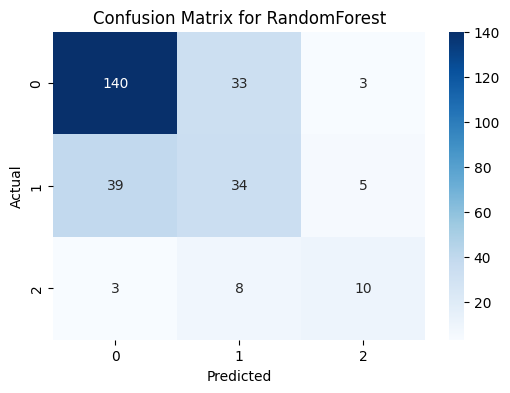


Confusion Matrix for GradientBoosting:
[[132  39   5]
 [ 37  31  10]
 [  4   9   8]]


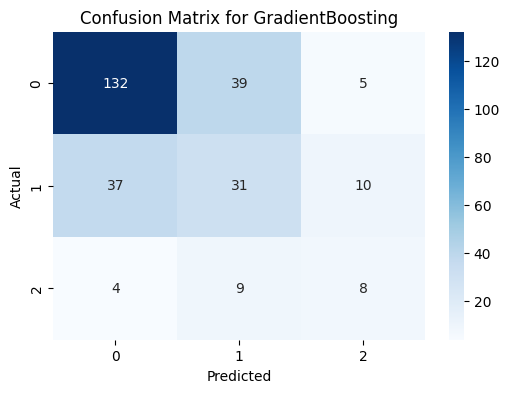


Confusion Matrix for LogisticRegression:
[[149  24   3]
 [ 45  22  11]
 [  3   6  12]]


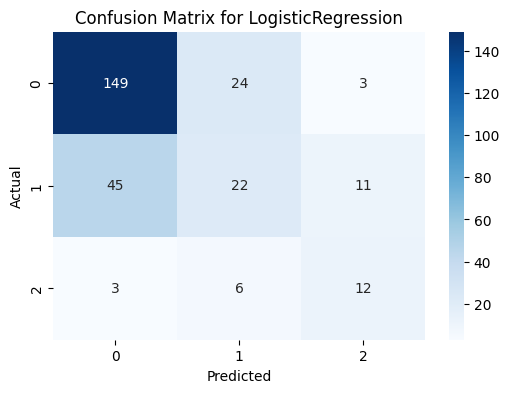


Confusion Matrix for SVC_linear:
[[153  20   3]
 [ 46  18  14]
 [  6   4  11]]


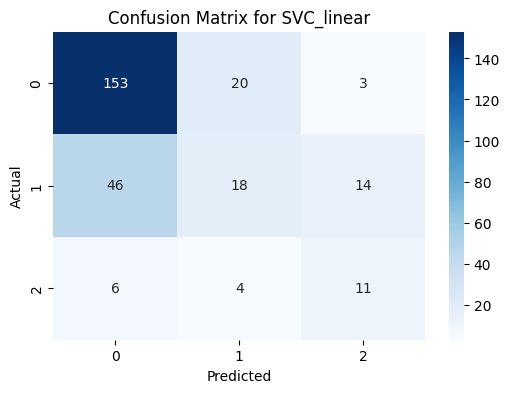


Confusion Matrix for SVC_rbf:
[[175   0   1]
 [ 78   0   0]
 [ 17   0   4]]


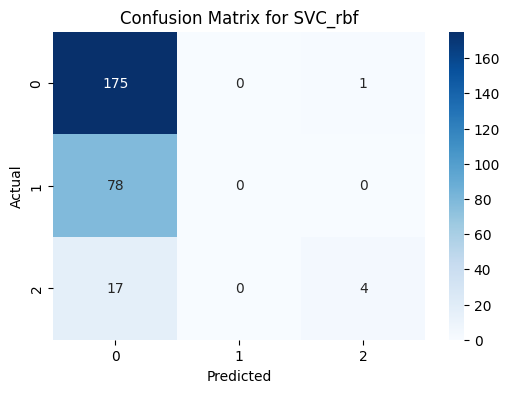

In [15]:
if ML == True:

  import matplotlib.pyplot as plt
  import seaborn as sns
  from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
  from sklearn.linear_model import LogisticRegression
  from sklearn.svm import SVC
  from sklearn.metrics import accuracy_score, confusion_matrix

  # Define predictors and target using the given column lists
  predictors = FEATURES
  target = TRUE_REGIME

  # Drop rows with missing values in predictors or target
  data = input_df.dropna(subset=predictors + [target]).reset_index(drop=True)
  X = data[predictors]
  y = data[target]
  # Also grab the DATE column for printing prediction timestamps
  dates = data[DATE]

  # Define the models
  models = {
      'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
      'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
      'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
      'SVC_linear': SVC(kernel='linear', probability=True, random_state=42),
      'SVC_rbf': SVC(kernel='rbf', probability=True, random_state=42)
  }

  window_size = 60  # e.g., 60 observations for training
  rolling_accuracies = {name: [] for name in models}

  # Dictionaries to store true and predicted labels for each model for confusion matrix calculation
  pred_true = {name: {'y_true': [], 'y_pred': []} for name in models}

  print("Starting rolling window evaluation:")

  # Loop over the dataset in a rolling window manner
  for i in range(len(X)):
      if i < window_size:
          print(f"Skipping prediction for timestamp {dates.iloc[i]} "
                f"(insufficient data: {i} observations available, need {window_size}).")
          continue

      # Training period is the previous window_size observations
      # Training period ends at the date corresponding to index i-1
      train_end = dates.iloc[i-1]
      # The prediction is for the date at index i
      test_date = dates.iloc[i]

      X_train_window = X.iloc[i-window_size:i]
      y_train_window = y.iloc[i-window_size:i]
      X_test_window = X.iloc[[i]]
      y_test_window = y.iloc[[i]]

      # Loop through each model, fit, predict and print the training end date and prediction date
      for name, model in models.items():
          model.fit(X_train_window, y_train_window)
          y_pred = model.predict(X_test_window)
          acc = accuracy_score(y_test_window, y_pred)
          print(f"Training period ended at {train_end} - Prediction for period {test_date}: "
                f"Model '{name}' Accuracy = {acc:.2f}")
          rolling_accuracies[name].append(acc)
          # Save true and predicted values for confusion matrix calculation
          pred_true[name]['y_true'].append(y_test_window.values[0])
          pred_true[name]['y_pred'].append(y_pred[0])

  # Print average rolling window accuracy for each model
  print("\nRolling Window Average Accuracy:")
  for name, acc_list in rolling_accuracies.items():
      avg_acc = np.mean(acc_list) if acc_list else 0
      print(f"{name}: {avg_acc:.2f}")

  # Compute and display confusion matrix for each model
  for name in models:
      cm = confusion_matrix(pred_true[name]['y_true'], pred_true[name]['y_pred'])
      print(f"\nConfusion Matrix for {name}:")
      print(cm)

      # Plot confusion matrix heatmap
      plt.figure(figsize=(6, 4))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
      plt.title(f'Confusion Matrix for {name}')
      plt.ylabel('Actual')
      plt.xlabel('Predicted')
      plt.show()


In [16]:
if DL == True:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
    import xgboost as xgb
    from sklearn.metrics import confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Parameters:
    training_window = 120  # Use the previous 120 months as training data
    seq_len = 60           # Generate overlapping sequences of 60 months within the training window
    num_classes = cluster_n  # Regimes are assumed to be labeled 0, 1, 2
    num_features = len(FEATURES)

    all_preds = []   # To store predictions
    all_true = []    # To store true regime labels
    dates_list = []  # To store corresponding dates

    # Ensure data is sorted by date
    data = input_df.sort_values(DATE).reset_index(drop=True)

    # Rolling window: start at index = training_window until end of data
    for i in range(training_window, len(data)):
        # Use the previous 120 months as the training window
        train_window = data.iloc[i - training_window:i].reset_index(drop=True)
        if len(train_window) < training_window:
            continue

        # Generate overlapping sequences of length 60 within the training window
        X_train_sequences = []
        y_train = []
        for j in range(len(train_window) - seq_len + 1):
            seq = train_window[FEATURES].iloc[j : j + seq_len].values
            target = train_window[TRUE_REGIME].iloc[j + seq_len - 1]  # target is the regime at the end of the sequence
            X_train_sequences.append(seq)
            y_train.append(target)
        X_train_sequences = np.array(X_train_sequences)  # shape: (num_samples, seq_len, num_features)
        y_train = np.array(y_train)

        # Build an LSTM feature extractor model using an Input layer
        input_layer = Input(shape=(seq_len, num_features))
        lstm_out = LSTM(32, return_sequences=False)(input_layer)
        dropout_out = Dropout(0.2)(lstm_out)
        feature_extractor = Model(inputs=input_layer, outputs=dropout_out)

        # Extract features from the training sequences
        X_train_features = feature_extractor.predict(X_train_sequences, verbose=0)

        # Train an XGBoost classifier on these features.
        clf = xgb.XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='mlogloss')
        clf.fit(X_train_features, y_train)

        # For prediction, use the last 60-month sequence in the training window
        X_pred_seq = train_window[FEATURES].iloc[-seq_len:].values.reshape(1, seq_len, num_features)
        X_pred_feature = feature_extractor.predict(X_pred_seq, verbose=0)
        pred_regime = clf.predict(X_pred_feature)[0]

        # The true regime for the next month (time index i)
        true_regime = data[TRUE_REGIME].iloc[i]

        all_preds.append(pred_regime)
        all_true.append(true_regime)
        dates_list.append(data[DATE].iloc[i])

        print(f"Prediction for {data[DATE].iloc[i]}: Predicted={pred_regime}, True={true_regime}")

    # Compute overall accuracy
    accuracy = accuracy_score(all_true, all_preds)
    print(f"\nOverall Accuracy: {accuracy*100:.2f}%")

    # Create and visualize the confusion matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Rolling Window Hybrid (LSTM + XGBoost) Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
